In [1]:
vlib =  c("tidyverse", "ggpubr", "arrow", "ComplexHeatmap", "Seurat",
         "tidyseurat", "enrichR", "ComplexHeatmap", "enrichR",
         "presto", "patchwork", "ggpmisc", "ggrepel", "broom", "viridis")
lapply(vlib, require, character.only = TRUE, quietly = TRUE) |> suppressMessages()

base_dir = "/data/nfs_dell/project_HS/LungCancer_ICI_sceQTL_2024/analysis/"
setwd(base_dir)

saveRDS.gz <- function(object, file, threads = 4) {
  con <- pipe(paste0("pigz -p", threads, " > ", file), "wb")
  saveRDS(object, file = con)
  close(con)
}
readRDS.gz <- function(file, threads = parallel::detectCores()) {
  con <- pipe(paste0("pigz -d -c -p", threads, " ", file))
  object <- readRDS(file = con)
  close(con)
  return(object)
}

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] FALSE

[[5]]
[1] FALSE

[[6]]
[1] FALSE

[[7]]
[1] TRUE

[[8]]
[1] FALSE

[[9]]
[1] TRUE

[[10]]
[1] FALSE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

## figure 4D
due to large size of SCENIC GRN matrix, we provide a DE-GRN matrix for visualization.

In [2]:
df_diff_grn = read_delim("assets/SCENIC/scenic_DE_GRN.txt.gz")

Rows: 522 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): feature, group
dbl (8): avgExpr, logFC, statistic, auc, pval, padj, pct_in, pct_out

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
c_cd8_scenic_regulon = df_diff_grn %>% distinct(feature) %>% pull()

In [4]:
c_cluster = "CD8"
df_map_cis = read_delim("assets/02_mashr/joined_all_results.txt.gz")
df_eGene = df_map_cis %>% filter(lfsr < 0.05)
c_eGene = df_eGene %>% filter(grepl(c_cluster, condition)) %>% distinct(phenotype_id) %>% pull()
c_noteGene = df_map_cis %>%
  filter(!phenotype_id %in% c_eGene) %>%
  filter(grepl(c_cluster, condition)) %>%
  distinct(phenotype_id) %>%
  pull()

Rows: 69897 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): phenotype_id, variant_id, condition, prefix_file, name
dbl (10): lfsr, PosteriorMean, PosteriorSD, start_distance, af, ma_samples, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
adj_mtx = read_delim("assets/SCENIC/adj.csv.gz")

df_cd8_regulone_enriched = adj_mtx %>%
  mutate(eGene = ifelse(target %in% c_eGene, "eGene",
                        ifelse(target %in% c_noteGene, "not_eGene", NA))) %>%
  na.omit() %>%
  group_by(TF, eGene) %>%
  summarise(n = n()) %>%
  pivot_wider(names_from = "eGene", values_from = n) %>%
  filter(TF %in% str_sub(c_cd8_scenic_regulon, 1, -4)) %>%
  mutate(ratio = eGene/(eGene + not_eGene)) %>%
  arrange(-ratio)

Rows: 1381032 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): TF, target
dbl (1): importance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `eGene = ifelse(...)`.
[1mCaused by error:[22m
[33m![39m object 'c_eGene' not found


In [ ]:
pSCENIC_DEGRN = df_diff_grn %>%
  filter(group == "PD base CD8") %>%
  mutate(feature = str_sub(feature, 1, -4)) %>%
  left_join(df_cd8_regulone_enriched, by = c("feature" = "TF"))  %>%
  arrange(padj) %>%
  mutate(label = ifelse((abs(logFC) > 0.005), feature, "")) %>%
  na.omit() %>%
  ggplot(aes(x = logFC, y = -log10(padj))) +
  geom_vline(xintercept = c(-0.005, 0.005), color = "grey90") +
  geom_hline(yintercept = c(-log10(1e-5)), color = "grey90")+
  geom_point() +
  geom_text_repel(aes(label = label)) +
  theme_pubr()

options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
pSCENIC_DEGRN
ggsave("figure_prep/pSCENIC_DEGRN.pdf",pSCENIC_DEGRN, width = 4, height = 4, dpi = 300)

## figure 4E

In [5]:
fname_module_score = "assets/wgcna/module_gene_scored.CD8.RNA.txt.gz"
df_module_score = read_delim(fname_module_score, delim = "\t")
list_adj_moduleScore = left_join(adj_mtx, df_module_score, by = c("target" = "gene_name")) %>%
  filter(TF %in% str_sub(c_cd8_scenic_regulon, 1, -4)) %>%
  group_by(TF, color) %>%
  group_split()

Rows: 3084 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, color
dbl (1): value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
list_res_tidy = vector(mode = "list", length = length(list_adj_moduleScore))
list_res_glance = vector(mode = "list", length = length(list_adj_moduleScore))
for (i in seq_along(list_adj_moduleScore)){
  tryCatch({
    each_lm = list_adj_moduleScore[[i]] %>%
      lm(importance ~ value, data = .)
    list_res_tidy[[i]] = each_lm %>%
      broom::tidy() %>%
      mutate(TF = list_adj_moduleScore[[i]]$TF[1],
             color = list_adj_moduleScore[[i]]$color[1])
    list_res_glance[[i]] = each_lm %>%
      broom::glance() %>%
      mutate(TF = list_adj_moduleScore[[i]]$TF[1],
             color = list_adj_moduleScore[[i]]$color[1])
  },
  error = function(e) {
    list_res_tidy[[i]] = NA
    list_res_glance[[i]] = NA
  }
  )
}

df_res_tidy = list_res_tidy %>% bind_rows()
df_res_glance = list_res_glance %>% bind_rows()

In [ ]:
df_diff_grn_significant = df_diff_grn %>%
  filter(feature %in% c_cd8_scenic_regulon,
    group == "PD base CD8",
    abs(logFC) > 0.005
  )

p_heatmap_padj = df_res_tidy %>% 
  mutate(p.adj = p.adjust(p.value, method= "BH")) %>%
  filter(term == "value",
         TF %in% str_sub(df_diff_grn_significant$feature, 1, -4)) %>%
  select(p.adj, TF, color) %>%
  mutate(p.adj = ifelse(p.adj < 0.05, -log10(p.adj), 
                        ifelse(is.na(p.adj) == TRUE, 0, 0))) %>%
  pivot_wider(names_from = TF, values_from = p.adj, values_fill = 0) %>%
  as.data.frame() %>%
  column_to_rownames("color") %>%
  t() %>%
  Heatmap(
    heatmap_legend_param = list(
      title = "p.adj"
    ),
    col = colorRamp2(c(0, -log10(0.05), 10), c("#53799d", "white", "#E23222")),
    column_dend_height = unit(0.5, "cm"),
    row_dend_width = unit(0.5, "cm")
  )
  p_heatmap_padj

pdf("figure_prep/pSCENIC_heatmap_padj.pdf", width = 5, height = 5)
p_heatmap_padj
dev.off()

## figure 4F

In [6]:
#df_scenic_module_merged = read_delim("SCENIC/TBX21_EOMES_forplot.txt.gz", delim = "\t")
df_scenic_module_merged = read_delim("/data/nfs_dell/project_HS/LungCancer_ICI_sceQTL_2024/analysis/assets/SCENIC/TBX21_EOMES_forplot.txt.gz", delim = "\t")

Rows: 78090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): cellID, anno_l1, anno_l2
dbl (3): brown, TBX21(+), EOMES(+)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“Computation failed in `stat_binhex()`.
Caused by error in `compute_group()`:
! The package "hexbin" is required for `stat_bin_hex()`.”
Warning message:
“Computation failed in `stat_binhex()`.
Caused by error in `compute_group()`:
! The package "hexbin" is required for `stat_bin_hex()`.”


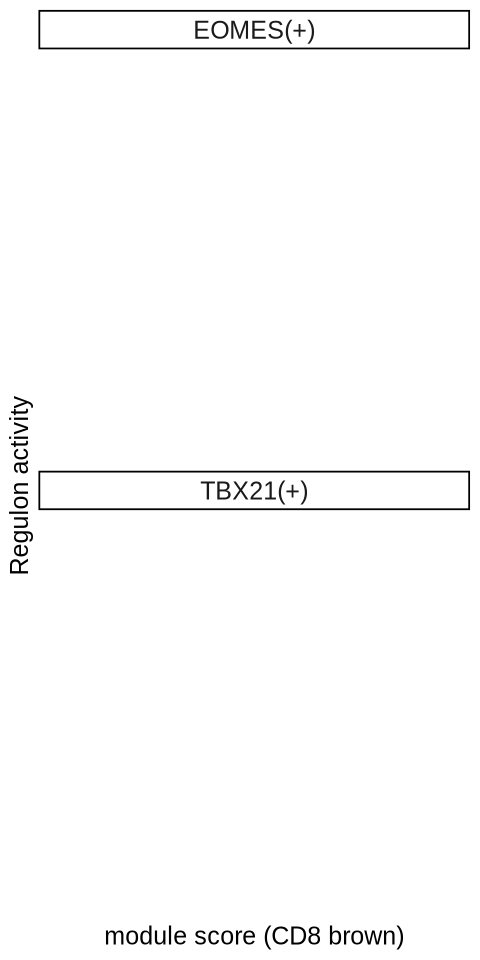

In [8]:
p_corr_plot = df_scenic_module_merged %>%
  filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 5:6) %>%
  ggplot(aes(x = brown, y = value)) +
  geom_hex(bins = 40) +
  facet_wrap(~name, ncol = 1, scales = "free") +
  scale_fill_viridis_c(option = "rocket", direction = -1) +
  stat_correlation(size = 6) +
  stat_poly_eq(aes(label = paste(after_stat(p.value.label))), vjust = +4, size = 6) +
  xlab("module score (CD8 brown)") +
  ylab("Regulon activity") +
  theme_pubr() +
  theme(
    legend.key.height = unit(0.2, "cm"),
    axis.title = element_text(size = 15),
    axis.text = element_text(size = 13),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )

options(repr.plot.width = 4, repr.plot.height = 8)
p_corr_plot

In [7]:
df_md = read_delim("/data/nfs_dell/project_HS/202310-sceqtl_v6/scRNA_GRN_scenic/raw_obj.seurat_md.txt.gz")

Rows: 559714 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, orig.ident, sample, time, sample_time, file, anno_l2, anno...
dbl (12): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, leiden, Sex, A...
lgl  (4): CHIP_BEFORE_SEVERE, CHIP_BEFORE_BINARY, CHIP_AFTER_SEVERE, CHIP_AF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## figure 4G

Joining with `by = join_by(cellID)`


Joining with `by = join_by(cellID)`


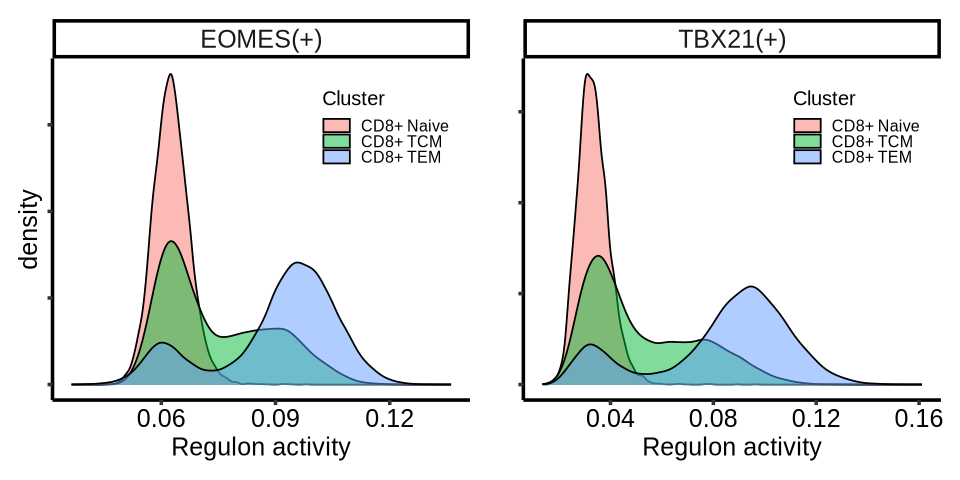

In [8]:
options(repr.plot.width = 8, repr.plot.height = 4)
p1 = df_md %>% 
 select(cellID, sample_time, Response) %>% 
 left_join(df_scenic_module_merged) %>% filter(is.na(anno_l1 )==FALSE) %>% 
 select(cellID, sample_time, anno_l1, anno_l2, `EOMES(+)`) %>%
  filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 5) %>%
  mutate(Cluster = str_replace(anno_l2, "_", "+ ")) %>%
  ggplot(aes(x = value, fill = Cluster)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~name, nrow = 3, scales = "free") +
  guides(fill = guide_legend(position = "inside")) +
   xlab('Regulon activity')+
  theme_pubr() +
  theme(
    legend.key.height = unit(0.2, "cm"),
    legend.position.inside = c(0.8, 0.8),
    axis.title = element_text(size = 15),
    axis.text.x = element_text(size = 15),
    axis.text.y = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(linewidth = 1),
    strip.background = element_rect(fill = NA, linewidth = 2),
    strip.text = element_text(size = 15)
  )


p2 = df_md %>% 
 select(cellID, sample_time, Response) %>% 
 left_join(df_scenic_module_merged) %>% filter(is.na(anno_l1 )==FALSE) %>% 
 select(cellID, sample_time, anno_l1, anno_l2, `TBX21(+)`) %>%
   filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 5) %>%
  mutate(Cluster = str_replace(anno_l2, "_", "+ ")) %>%
  ggplot(aes(x = value, fill = Cluster)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~name, nrow = 3, scales = "free") +
  guides(fill = guide_legend(position = "inside")) +
  theme_pubr() +
  ylab('')+
  xlab('Regulon activity')+
  theme(
    legend.key.height = unit(0.2, "cm"),
    legend.position.inside = c(0.8, 0.8),
    axis.title = element_text(size = 15),
    axis.text.x = element_text(size = 15),
    axis.text.y = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(linewidth = 1),
    strip.background = element_rect(fill = NA, linewidth = 2),
    strip.text = element_text(size = 15)
  )

(p1 + p2)

ggsave("/data/nfs_dell/project_HS/LungCancer_ICI_sceQTL_2024/analysis/figure_prep/S6_EOMES_TBX21_density.pdf",
  width = 8, height = 4, dpi = 300)

In [22]:

options(repr.plot.width = 4, repr.plot.height = 4)
p_comp_value = df_scenic_module_merged %>%
  select(cellID, sample_time, anno_l1, anno_l2, `TBX21(+)`) %>%
  filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 5) %>%
  ggplot(aes(x = value, fill = anno_l2)) +
  geom_density(alpha = 0.5) +
  facet_wrap(~name, nrow = 3, scales = "free") +
  guides(fill = guide_legend(position = "inside")) +
  theme_pubr() +
  theme(
    legend.key.height = unit(0.2, "cm"),
    legend.position.inside = c(0.8, 0.8),
    axis.title = element_text(size = 15),
    axis.text.y = element_blank(),
    axis.text.x = element_blank(),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )
p_comp_value

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `sample_time` doesn't exist.


## figure 4H

Joining with `by = join_by(cellID, anno_l1, anno_l2)`
`summarise()` has grouped output by 'sample', 'time', 'Response', 'anno_l2'.
You can override using the `.groups` argument.
Joining with `by = join_by(cellID, anno_l1, anno_l2)`
`summarise()` has grouped output by 'sample', 'time', 'Response', 'anno_l2'.
You can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


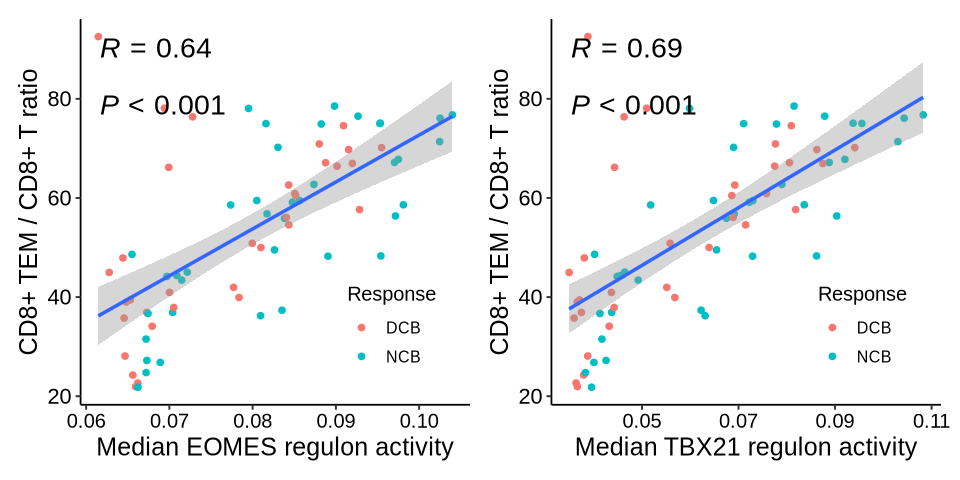

In [13]:
p1 = df_md %>% 
 select(cellID, sample, time, Response, anno_l1, anno_l2,  Response) %>% 
 left_join(df_scenic_module_merged) %>% filter(is.na(anno_l1 )==FALSE) %>% 
  select(cellID, sample, time, Response, anno_l1, anno_l2, `EOMES(+)`) %>%
 filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 7) %>%
  group_by(sample, time, Response) %>%
  mutate(median_tbx21 = median(value)) %>%
  ungroup() %>%
  group_by(sample, time, Response, anno_l2, median_tbx21) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  group_by(sample, time, Response) %>%
  mutate(ratio = n / sum(n) * 100, Response = ifelse(Response == "PR", "DCB", "NCB")) %>%
  filter(anno_l2 == "CD8_TEM", time == "base")  %>%
  ggplot(aes(x =median_tbx21, y = ratio)) +
  geom_point(aes(color = Response)) +
  geom_smooth(method = "lm") +
  stat_correlation(size = 6) +
  stat_poly_eq(aes(label = paste(after_stat(p.value.label))), vjust = +4, size = 6) +

  theme_pubr() +
  xlab("Median EOMES regulon activity") +
  ylab("CD8+ TEM / CD8+ T ratio") +
  guides(color = guide_legend(position = "inside")) +
  theme(
    legend.position.inside = c(0.8, 0.2),
    axis.title = element_text(size = 15),
    axis.text.y = element_text(size = 13),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )

p2 = df_md %>% 
 select(cellID, sample, time, Response, anno_l1, anno_l2,  Response) %>% 
 left_join(df_scenic_module_merged) %>% filter(is.na(anno_l1 )==FALSE) %>% 
  select(cellID, sample, time, Response, anno_l1, anno_l2, `TBX21(+)`) %>%
 filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 7) %>%
  group_by(sample, time, Response) %>%
  mutate(median_tbx21 = median(value)) %>%
  ungroup() %>%
  group_by(sample, time, Response, anno_l2, median_tbx21) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  group_by(sample, time, Response) %>%
  mutate(ratio = n / sum(n) * 100, Response = ifelse(Response == "PR", "DCB", "NCB")) %>%
  filter(anno_l2 == "CD8_TEM", time == "base")  %>%
  ggplot(aes(x =median_tbx21, y = ratio)) +
  geom_point(aes(color = Response)) +
  geom_smooth(method = "lm") +
  stat_correlation(size = 6) +
  stat_poly_eq(aes(label = paste(after_stat(p.value.label))), vjust = +4, size = 6) +
  theme_pubr() +
  xlab("Median TBX21 regulon activity") +
  ylab("CD8+ TEM / CD8+ T ratio") +
  guides(color = guide_legend(position = "inside")) +
  theme(
    legend.position.inside = c(0.8, 0.2),
    axis.title = element_text(size = 15),
    axis.text.y = element_text(size = 13),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )

p1 + p2

ggsave("/data/nfs_dell/project_HS/LungCancer_ICI_sceQTL_2024/analysis/figure_prep/S6_EOMES_TBX21_TEM.pdf",
  width = 8, height = 4, dpi = 300)

In [ ]:
p_comp_tbx21 = left_join(df_eachcell_module_scored, seurat_obj_aucmtx) %>%
  select(cellID, sample, time, Response, anno_l1, anno_l2, `TBX21(+)`) %>%
  filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 7) %>%
  group_by(sample, time, Response) %>%
  mutate(median_tbx21 = median(value)) %>%
  ungroup() %>%
  group_by(sample, time, Response, anno_l2, median_tbx21) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  group_by(sample, time, Response) %>%
  mutate(ratio = n / sum(n) * 100, key = "CD8 TEM ratio") %>%
  filter(anno_l2 == "CD8_TEM", time == "base") %>%
  ggplot(aes(x =median_tbx21, y = ratio)) +
  geom_point(aes(color = Response)) +
  geom_smooth(method = "lm") +
  stat_correlation(size = 6) +
  stat_poly_eq(aes(label = paste(after_stat(p.value.label))), vjust = +4, size = 6) +
  facet_wrap(~key)+
  theme_pubr() +
  xlab("median TBX21 regulon activity") +
  ylab("CD8 TEM ratio") +
  guides(color = guide_legend(position = "inside")) +
  theme(
    legend.position.inside = c(0.8, 0.2),
    axis.title = element_text(size = 15),
    axis.text.y = element_text(size = 13),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )
  options(repr.plot.width = 4, repr.plot.height = 4)
  p_comp_tbx21

In [ ]:
p_comp_tbx21 = left_join(df_eachcell_module_scored, seurat_obj_aucmtx) %>%
  select(cellID, sample, time, Response, anno_l1, anno_l2, `TBX21(+)`) %>%
  filter(anno_l1 == "CD8") %>%
  pivot_longer(cols = 7) %>%
  group_by(sample, time, Response) %>%
  mutate(median_tbx21 = median(value)) %>%
  ungroup() %>%
  group_by(sample, time, Response, anno_l2, median_tbx21) %>%
  summarise(n = n()) %>%
  ungroup() %>%
  group_by(sample, time, Response) %>%
  mutate(ratio = n / sum(n) * 100, key = "CD8 TEM ratio") %>%
  filter(anno_l2 == "CD8_TEM", time == "base") %>%
  ggplot(aes(x =median_tbx21, y = ratio)) +
  geom_point(aes(color = Response)) +
  geom_smooth(method = "lm") +
  stat_correlation(size = 6) +
  stat_poly_eq(aes(label = paste(after_stat(p.value.label))), vjust = +4, size = 6) +
  facet_wrap(~key)+
  theme_pubr() +
  xlab("median TBX21 regulon activity") +
  ylab("CD8 TEM ratio") +
  guides(color = guide_legend(position = "inside")) +
  theme(
    legend.position.inside = c(0.8, 0.2),
    axis.title = element_text(size = 15),
    axis.text.y = element_text(size = 13),
    strip.background = element_rect(fill = NA, linewidth = 1),
    strip.text = element_text(size = 15)
  )
  options(repr.plot.width = 4, repr.plot.height = 4)
  p_comp_tbx21 

Joining with `by = join_by(cellID)`
`summarise()` has grouped output by 'sample', 'time', 'Response', 'anno_l2'.
You can override using the `.groups` argument.


ERROR: Error in stat_correlation(size = 6): could not find function "stat_correlation"


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8)
(p_corr_plot + (p_comp_value /  p_comp_tbx21)) %>%
  ggsave("figure_prep/pSCENIC_corr_value_gathered.pdf", ., width = 8, height = 8, dpi = 300)